In [1]:
# installs
!pip install opencv-python
!pip3 install resnet_pytorch

In [2]:
# imports%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torchvision
import pandas as pd
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from resnet_pytorch import ResNet 

from PIL import Image
# import PIL.Image
import os
import glob
import numpy as np
import cv2 as cv
import io
from IPython.display import clear_output, display
from tqdm import tqdm

import matplotlib.pyplot as plt
import warnings
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')

In [3]:
### global stuff
# DATA_FOLDER:
# contains data_labels.txt, with_rips folder images and without_rips folder images
DATA_FOLDER = "./training_data" 
images_rip = glob.glob(os.path.join(DATA_FOLDER, "with_rips/*.png")) 
images_norip = glob.glob(os.path.join(DATA_FOLDER, "without_rips/*.png")) 

In [4]:
def data_load_preprocess_split(DATA_FOLDER, split_size = 0.2):
    preprocess_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.RandomVerticalFlip(0.5),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    preprocess_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    data = datasets.ImageFolder(DATA_FOLDER, transform = preprocess_test)
    
    data_size = len(data)
    idxs = list(range(data_size))
    
    split = int(np.floor(split_size * data_size))
    
    np.random.shuffle(idxs)
    
    train_idx, validation_idx, test_idx = idxs[split*2:], idxs[split:split*2], idxs[:split]
    
    train_sampler = SubsetRandomSampler(train_idx)
    validation_sampler = SubsetRandomSampler(validation_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    train_loader = torch.utils.data.DataLoader(data, sampler = train_sampler, batch_size=128, num_workers=8)
    validation_loader = torch.utils.data.DataLoader(data, sampler = validation_sampler, batch_size=256, num_workers=8)
    test_loader = torch.utils.data.DataLoader(data, sampler = test_sampler, batch_size=256, num_workers=8)
    
    return train_loader, validation_loader, test_loader, preprocess_train

train_loader, validation_loader, test_loader, preprocess_train = data_load_preprocess_split(DATA_FOLDER, 0.2)

print(train_loader.dataset.classes)

['with_rips', 'without_rips']


In [5]:
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 2482
    Root location: ./training_data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [6]:
test_loader.dataset

Dataset ImageFolder
    Number of datapoints: 2482
    Root location: ./training_data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

In [8]:
model = models.resnet18(pretrained=True)

# model = models.resnet50(pretrained=True)

# free the model
for param in model.parameters():
    param.requires_grad = False
    
# resnet-18
model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 2),
    nn.LogSoftmax(dim=1)
)

# resnet-50
# model.fc = nn.Sequential(
#     nn.Linear(2048, 512),
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(512, 2),
#     nn.LogSoftmax(dim=1)
# )

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model = model.to(device)

In [9]:
device

device(type='cuda')

In [10]:
epochs = 25 

train_losses, validation_losses = [], []

train_accuracies, validation_accuracies = [], []

# early stopping
epochs_limit = 6
epochs_without_improvement = 0
min_validation_loss = np.Inf

for epoch in range(epochs):
    train_loss = 0.0
    validation_loss = 0.0
    
    train_accuracy = 0
    validation_accuracy = 0
    
    total_validation = 0
    total_train = 0
    
    train_loader.dataset.Transform = preprocess_train
    for inputs, labels in tqdm(train_loader, desc='Train'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        prediction = model(inputs.to(device))
        
        loss = criterion(prediction, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        total_train += labels.size(0)
        train_accuracy += (prediction.argmax(dim=1) == labels).sum().item()
        
    train_losses.append(train_loss)
    train_accuracies.append(100 * train_accuracy / total_train)

    model.eval()  
    
    with torch.no_grad():
        for inputs, labels in tqdm(validation_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)

            prediction = model(inputs)

            loss = criterion(prediction, labels)

            validation_loss += loss.item()
            total_validation += labels.size(0)
            validation_accuracy += (prediction.argmax(dim=1) == labels).sum().item()
            
    validation_losses.append(validation_loss)
    validation_accuracies.append(100 * validation_accuracy / total_validation)
        
    if (validation_loss < min_validation_loss):
        epochs_without_improvement = 0
        min_validation_loss = validation_loss
    elif (epoch > 5):
        epochs_without_improvement += 1
        print(epochs_without_improvement)

    if (epoch > 5 and epochs_without_improvement >= epochs_limit):
        print("Early stopping")
        print(f'Epoch {epoch + 1}')
        print("Stopping model training.")
        break;
    else:
        torch.save(model, 'rip-resnet18-adam-full.pth')
    
    print(f'Epoch {epoch + 1}')
    print(f'Training Loss: {train_loss / len(train_loader)}\t Train Accuracy: {100 * train_accuracy / total_train}')
    print(f'Validation Loss: {validation_loss / len(validation_loader)} \t Validation Accuracy: {100 * validation_accuracy / total_validation}')

Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1
Training Loss: 0.8212136526902517	 Train Accuracy: 63.624161073825505
Validation Loss: 0.5857245326042175 	 Validation Accuracy: 70.96774193548387


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2
Training Loss: 0.5138047138849894	 Train Accuracy: 72.68456375838926
Validation Loss: 0.4947734624147415 	 Validation Accuracy: 72.58064516129032


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3
Training Loss: 0.447786142428716	 Train Accuracy: 75.43624161073825
Validation Loss: 0.4370056986808777 	 Validation Accuracy: 81.45161290322581


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4
Training Loss: 0.384911373257637	 Train Accuracy: 83.8255033557047
Validation Loss: 0.37390103936195374 	 Validation Accuracy: 87.70161290322581


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5
Training Loss: 0.31505385786294937	 Train Accuracy: 87.78523489932886
Validation Loss: 0.31244172155857086 	 Validation Accuracy: 89.51612903225806


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6
Training Loss: 0.25871825342377025	 Train Accuracy: 90.20134228187919
Validation Loss: 0.27523550391197205 	 Validation Accuracy: 87.90322580645162


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7
Training Loss: 0.2220685382684072	 Train Accuracy: 91.74496644295301
Validation Loss: 0.25722847878932953 	 Validation Accuracy: 89.11290322580645


Train:   0%|          | 0/12 [00:00<?, ?it/s]

1
Epoch 8
Training Loss: 0.21378017589449883	 Train Accuracy: 91.54362416107382
Validation Loss: 0.30090831220149994 	 Validation Accuracy: 87.90322580645162


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9
Training Loss: 0.18988898396492004	 Train Accuracy: 92.21476510067114
Validation Loss: 0.24873116612434387 	 Validation Accuracy: 90.5241935483871


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10
Training Loss: 0.17210609838366508	 Train Accuracy: 93.22147651006712
Validation Loss: 0.24388594180345535 	 Validation Accuracy: 90.12096774193549


Train:   0%|          | 0/12 [00:00<?, ?it/s]

1
Epoch 11
Training Loss: 0.15559978038072586	 Train Accuracy: 94.16107382550335
Validation Loss: 0.24503593891859055 	 Validation Accuracy: 91.33064516129032


Train:   0%|          | 0/12 [00:00<?, ?it/s]

2
Epoch 12
Training Loss: 0.14306830304364362	 Train Accuracy: 94.76510067114094
Validation Loss: 0.2519175410270691 	 Validation Accuracy: 91.12903225806451


Train:   0%|          | 0/12 [00:00<?, ?it/s]

3
Epoch 13
Training Loss: 0.13927615992724895	 Train Accuracy: 95.03355704697987
Validation Loss: 0.2609230875968933 	 Validation Accuracy: 91.33064516129032


Train:   0%|          | 0/12 [00:00<?, ?it/s]

4
Epoch 14
Training Loss: 0.12782157647113004	 Train Accuracy: 95.70469798657719
Validation Loss: 0.2568286582827568 	 Validation Accuracy: 90.9274193548387


Train:   0%|          | 0/12 [00:00<?, ?it/s]

5
Epoch 15
Training Loss: 0.12008210271596909	 Train Accuracy: 96.51006711409396
Validation Loss: 0.25192708522081375 	 Validation Accuracy: 90.3225806451613


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.82s/it]

6
Early stopping
Epoch 16
Stopping model training.


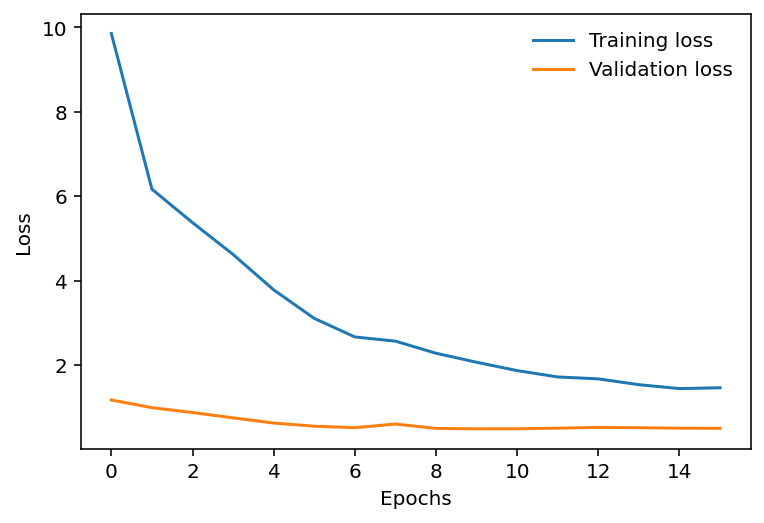

In [11]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(validation_losses, label = 'Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

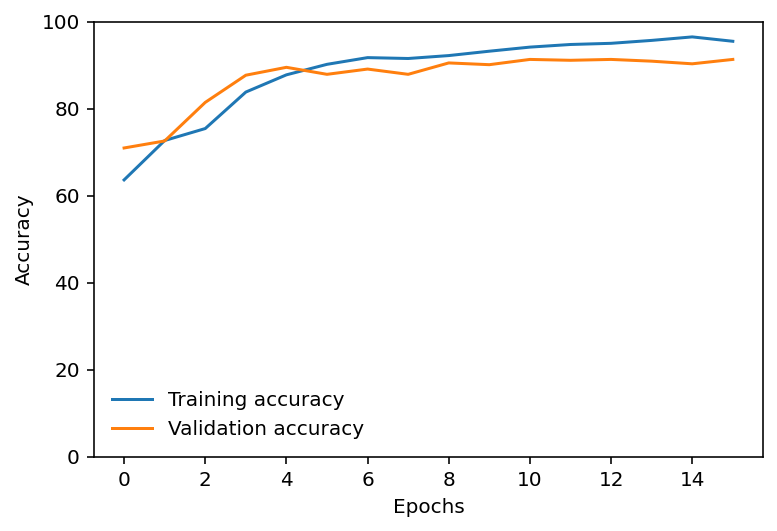

In [12]:
plt.ylim(0, 100)
plt.plot(train_accuracies, label = 'Training accuracy')
plt.plot(validation_accuracies, label = 'Validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)
plt.show()

In [13]:
model = torch.load('rip-resnet18-adam-full.pth')

test_accuracy = 0    
total_test = 0

model.eval()  

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Test'):
        inputs, labels = inputs.to(device), labels.to(device)

        prediction = model(inputs)
        all_labels.append(labels.cpu().numpy())
        
        predictions = prediction.argmax(dim=1)
        
        all_predictions.append(predictions.cpu().numpy())
#         loss = criterion(prediction, labels)

#     total_test = labels.size(0)
#     test_accuracy = (prediction.argmax(dim=1) == labels).sum().item()
    
# lista de numpy arrays -> only one list



Test: 100%|██████████| 2/2 [00:11<00:00,  5.77s/it]


In [14]:
all_labels = np.concatenate(all_labels,axis=0)
all_predictions = np.concatenate(all_predictions, axis=0)

In [15]:

clf_rep  = classification_report(all_labels, all_predictions)

print(clf_rep)

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       351
           1       0.83      0.86      0.84       145

    accuracy                           0.91       496
   macro avg       0.88      0.89      0.89       496
weighted avg       0.91      0.91      0.91       496



# Fully Connected